In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random

import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split

Before we start:
- Validation vs. Test
- Data Leakage

Today we are going to talk about **Classification**. The goal will be to classify each observation into one of potentially many classes. We'll start with *binary* classification, or classifying into one of two classes. The following data can be found [here](https://www.kaggle.com/faressayah/college-data).

In [2]:
# can we classify colleges as public or private?
# let's look at a sample of 500 colleges
df_college = pd.read_csv('data/college_data.csv').sample(n=200, random_state=2022).reset_index(drop=True)
# what does random_state do?
df_college.head()

,private,apps,accept,enroll,top10perc,top25perc,f_undergrad,p_undergrad,outstate,room_board,books,personal,phd,terminal,s_f_ratio,perc_alumni,expend,grad_rate
0,No,5659,4761,3147,10,31,8596,1949,6892,3706,600,2500,72,76,16.6,8,6996,40
1,Yes,8474,3446,911,75,94,3566,1569,18800,6740,500,1040,96,97,3.3,38,56233,90
2,Yes,8506,4168,1236,76,97,5544,192,17600,6000,600,870,97,98,5.0,28,28457,96
3,No,2320,1805,769,24,61,3395,670,6400,3392,580,2150,71,80,12.8,26,6729,59
4,No,6986,2959,1918,25,60,12330,7152,6618,4234,700,1600,80,98,22.2,9,6742,46


In [3]:
# create the variable is_private!
df_college['is_private'] = df_college['private'].apply(lambda x: int(x == 'Yes'))
df_college.head()

,private,apps,accept,enroll,top10perc,top25perc,f_undergrad,p_undergrad,outstate,room_board,books,personal,phd,terminal,s_f_ratio,perc_alumni,expend,grad_rate,is_private
0,No,5659,4761,3147,10,31,8596,1949,6892,3706,600,2500,72,76,16.6,8,6996,40,0
1,Yes,8474,3446,911,75,94,3566,1569,18800,6740,500,1040,96,97,3.3,38,56233,90,1
2,Yes,8506,4168,1236,76,97,5544,192,17600,6000,600,870,97,98,5.0,28,28457,96,1
3,No,2320,1805,769,24,61,3395,670,6400,3392,580,2150,71,80,12.8,26,6729,59,0
4,No,6986,2959,1918,25,60,12330,7152,6618,4234,700,1600,80,98,22.2,9,6742,46,0


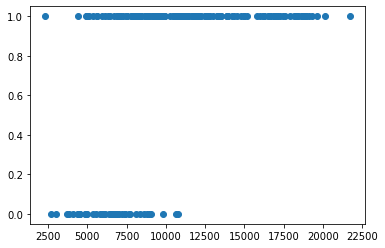

In [4]:
# does out of state tuition predict private/public?
plt.scatter(x=df_college['outstate'], y=df_college['is_private'])
plt.show()

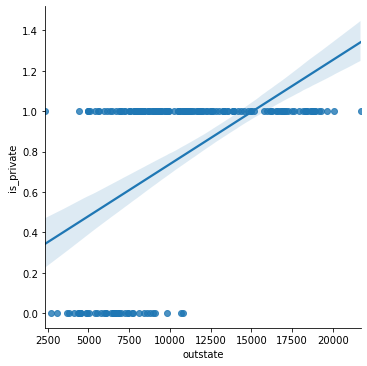

In [5]:
# linear regression doesn't seem to be the best here...
sns.lmplot(x='outstate', y='is_private', data=df_college)
plt.show()

In [6]:
df_college[['outstate', 'is_private']].corr()

,outstate,is_private
outstate,1.000000,0.525574
is_private,0.525574,1.000000


- Does binary data fit the assumptions from OLS regression?

The goal here will to predict the *probability* that a given observation falls into the class defined by $1$. In other words given independent variable $X$ and target variable $Y$, we want to find $P(Y=1|X)$. Additionaly we want to do with the same *linear* framework as before.

So let's instead try to predict the **Odds** of an event occurring. In sports betting, odds are often used instead of probability:

- "The San Francisco Giants are a long shot, they have 10-1 odds of winning."
- "There's no way the San Francisco 49ers are going to lose, the betting odds are one to five!"
- "Never tell me the odds." - Han Solo, *Star Wars*

If a event has probability $p$ of occuring, then the odds of the event are

$$
Odds = \frac{p}{1-p}
$$

- What is $p$ in the two sports examples above?

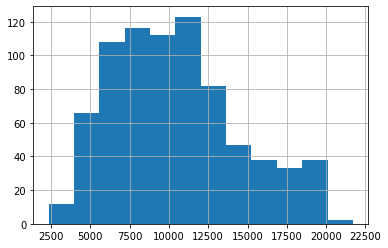

In [7]:
# full dataset
df_college = pd.read_csv('data/college_data.csv')
df_college['is_private'] = df_college['private'].apply(lambda x: int(x == 'Yes'))

df_college['outstate'].hist(bins=12)
plt.show()

In [8]:
# for each of these bins let's count the number of private schools to estimate P(is_private=1|outstate)
tuition_bins = pd.cut(df_college['outstate'], bins=12)
ct = pd.crosstab(tuition_bins,df_college['is_private'])
ct

is_private,0,1
outstate,,
"(2320.64, 3953.333]",11,1
"(3953.333, 5566.667]",49,17
"(5566.667, 7180.0]",75,33
"(7180.0, 8793.333]",47,69
"(8793.333, 10406.667]",16,96
"(10406.667, 12020.0]",9,114
"(12020.0, 13633.333]",2,80
"(13633.333, 15246.667]",1,46
"(15246.667, 16860.0]",2,36


In [9]:
ct['freq'] = (ct[1] / (ct[0] + ct[1]))
ct

is_private,0,1,freq
outstate,,,
"(2320.64, 3953.333]",11,1,0.083333
"(3953.333, 5566.667]",49,17,0.257576
"(5566.667, 7180.0]",75,33,0.305556
"(7180.0, 8793.333]",47,69,0.594828
"(8793.333, 10406.667]",16,96,0.857143
"(10406.667, 12020.0]",9,114,0.926829
"(12020.0, 13633.333]",2,80,0.975610
"(13633.333, 15246.667]",1,46,0.978723
"(15246.667, 16860.0]",2,36,0.947368


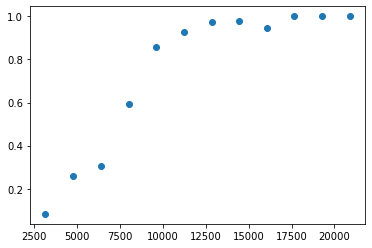

In [10]:
# get the midpoints
ct['midpoints'] = ct.index.to_series().apply(lambda x: x.mid)

# plot the frequency
plt.scatter(x=ct['midpoints'], y=ct['freq'])
plt.show()

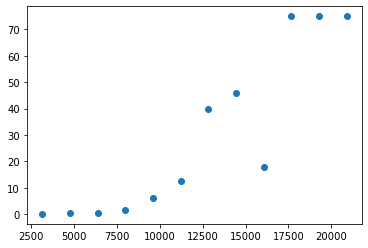

In [11]:
# get the odds
def odds(p):
    if p < 1.0:
        return (p / (1-p))
    
    # if the odds are "infinite" set a cap at 75
    else:
        return 75


ct['odds'] = ct['freq'].apply(odds)

# plot the odds
plt.scatter(x=ct['midpoints'], y=ct['odds'])
plt.show()

Now the Odds here don't look very linear... But the *log* of the odds does.

The number $e=2.718281828...$ is a special constant.
- The rate of change of the function $f(x)=e^x$ is given by $f'(x)=e^x$.
- We also have that $\displaystyle \lim_{n\rightarrow\infty} \left(1+ \frac{1}{n}\right)^n = e$ (related to compound interest)

Consider
$$
y = f(x) = e^x.
$$
This completely determines the inverse relationship, i.e. the function $x=g(y)$:
$$
\ln(y) = \log_e(y) = \log(y) = x
$$

Below we plot $\displaystyle \log\left(\frac{p}{1-p}\right)$ against the independent variable.

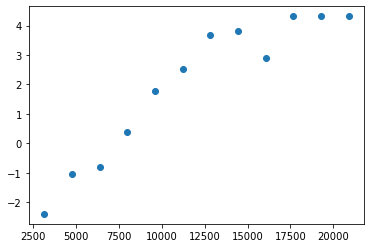

In [12]:
# looks a bit linear!
ct['log_odds'] = ct['odds'].apply(lambda x : math.log(x))

# plot the odds
plt.scatter(x=ct['midpoints'], y=ct['log_odds'])
plt.show()

### Logistic Regression

Find the parameters $\beta_0, \beta_1$ to create the model

$$
\log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 X
$$

Rearranging we have

$$
\begin{align}
\frac{p}{1-p} &= e^{\beta_0 +\beta_1 X}\\
1 + \frac{p}{1-p} &= 1 + e^{\beta_0 +\beta_1 X}\\
\frac{1}{1-p} &= 1 + e^{\beta_0 +\beta_1 X}\\
1-p &= \frac{1}{1 + e^{\beta_0 +\beta_1 X}}\\
1 - \frac{1}{1 + e^{\beta_0 +\beta_1 X}} &= p\\
\frac{ e^{\beta_0 +\beta_1 X}}{1 + e^{\beta_0 +\beta_1 X}} &= p\\
\frac{1}{ e^{-(\beta_0 +\beta_1 X)} + 1} &= p\\
p(X) &= \frac{1}{1 + e^{-(\beta_0 +\beta_1 X)}}
\end{align}
$$

Thus performing linear regression on the log-odds is equivalent to fitting a logistic function to the data.
- The function $p(x) = \frac{1}{1+e^{-x}}$ is called a *sigmoid* function.

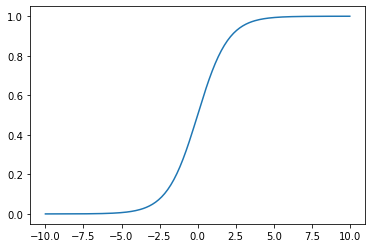

In [13]:
x = np.linspace(-10, 10, 200)
p = 1/(1 + np.exp(-x))
plt.plot(x, p)
plt.show()

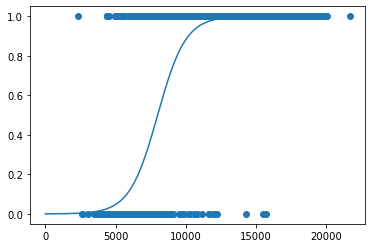

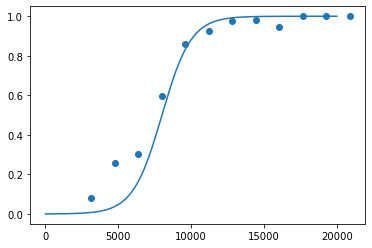

In [14]:
plt.scatter(x=df_college['outstate'], y=df_college['is_private'])

# logistic model
x = np.linspace(0, 20000, 10000)
p = 1/(1 + np.exp(-((1/1000)*x-8)))
plt.plot(x, p)
plt.show()

# scatter plot
plt.scatter(x=ct['midpoints'], y=ct['freq'])
plt.plot(x, p)
plt.show()

You can see here that the logistic model is estimating the probability values of the target variable with respect to the input variable.

- What is missing here before we can fit the model?

### Likelihood

- For our probability function and an observation $(x_i, y_i)$: What is the likelihood of $(x_i, y_i)$ occuring with the probability function $p(X)$?
- Note here $y_i = 0$ OR $y_i = 1$.

$$
\mathcal{L}(\beta_0, \beta_1) = p(x_i)^{y_i}(1-p(x_i))^{1-y_i}
$$

- We want to maximize the likelihood function!
- This is equivalent to maximizing the **log-likelihood** function:

$$
\mathcal{l}(\beta_0, \beta_1) = \log(p(x_i)^{y_i}(1-p(x_i))^{1-y_i}) = y_i\log(p(x_i)) + (1-y_i)\log(1-p(x_i))
$$

In turn this is equivalent to *minimizing* the negative log-likelihood function:

$$
-\mathcal{l}(\beta_0, \beta_1) = -y_i\log(p(\beta_0, \beta_1, x_i))) - (1-y_i)\log(1-p(\beta_0, \beta_1, x_i)
$$

- Note the inclusion of $\beta_0, \beta_1$ in the $p$ function.

For many observations we arrive at

$$
-\mathcal{l}(\beta_0, \beta_1) = \sum_{i=1}^N -y_i\log(p(\beta_0, \beta_1, x_i))) - (1-y_i)\log(1-p(\beta_0, \beta_1, x_i)
$$

### Summary

Given $N$ data points $(x_i, y_i)$, find parameters $\beta_0, \beta_1$ for the model
$$
p(X) = \frac{1}{1 + e^{-(\beta_0 +\beta_1 X)}}
$$
that minimize the loss function
$$
L(\beta_0,\beta_1) = -\left(\sum_{i=1}^N y_i\log(p) + (1-y_i)\log(1-p)\right)
$$

In [15]:
from statsmodels.formula.api import logit

model = logit(formula = 'is_private ~ outstate', data=df_college)
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.369942
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_private   No. Observations:                  777
Model:                          Logit   Df Residuals:                      775
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.3688
Time:                        19:42:08   Log-Likelihood:                -287.45
converged:                       True   LL-Null:                       -455.37
Covariance Type:            nonrobust   LLR p-value:                 5.093e-75
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.5221      0.409    -11.045      0.000      -5.325      -3.720
outstate       0.0006   4.96e-05     12.579      0.000       0.001       0.001
==============================================================================
"""

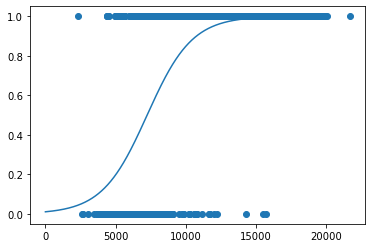

In [16]:
b0, b1 = res.params

# plot the model against the 0-1 values
plt.scatter(x=df_college['outstate'], y=df_college['is_private'])

x = np.linspace(0, 20000, 10000)
p = 1/(1 + np.exp(-(b1*x+b0)))
plt.plot(x, p)

plt.show()

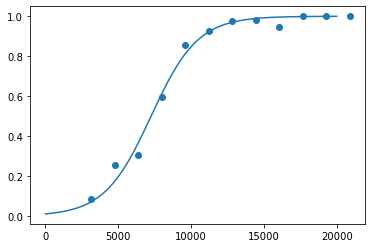

In [17]:
# plot the model against the estimated probabilities
plt.scatter(x=ct['midpoints'], y=ct['freq'])
plt.plot(x, p)
plt.show()

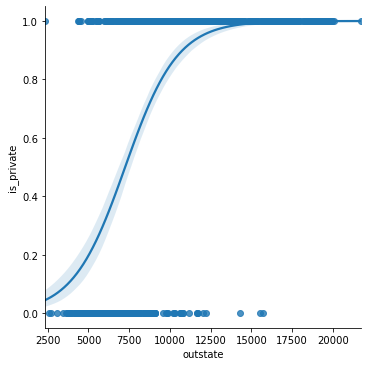

In [18]:
# we can also use seaborn's lmplot again
sns.lmplot(x="outstate", logistic=True, y="is_private", data=df_college)
plt.show()

### Classification Metrics
- How do we turn our probability prediction into a binary prediction?
- What does it mean to set a *threshold* of 0.5?

In [29]:
x = df_college['outstate']
y = df_college['is_private']

y_pred_prob = res.predict(x)
y_pred_prob[:20]

0     0.529243
1     0.958317
2     0.923637
3     0.972323
4     0.547836
5     0.980078
6     0.977354
7     0.984098
8     0.994525
9     0.881343
10    0.996971
11    0.997824
12    0.820551
13    0.965013
14    0.665028
15    0.711520
16    0.999590
17    0.855170
18    0.846952
19    0.210271
dtype: float64

In [36]:
y_pred = (y_pred_prob >= 0.5).apply(int)
y_pred[:20]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    0
dtype: int64

In [31]:
# let's utilize sklearn's metrics package
from sklearn import metrics

acc = metrics.accuracy_score(y, y_pred)
print(f'The Accuracy of this model is {100*acc}%')

The Accuracy of this model is 84.55598455598455%


Looks good... but how good is this really?

In [32]:
y_all_ones = np.ones(len(y))

acc = metrics.accuracy_score(y, y_all_ones)
print(f'The Accuracy of always predicting private is {100*acc}%')

The Accuracy of always predicting private is 72.71557271557272%


This is what we call an *imbalanced* dataset. There is not an even 50/50 split of private and public schools. To get a better idea of how our model is performing we can look at the **Confusion Matrix**

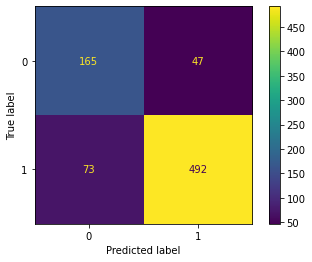

In [33]:
# build the confusion matrix
cm = metrics.confusion_matrix(y, y_pred)
# display it nicely
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The bottom left corner are the number of False Negatives and the top right corner are the number of False Positive.

- The **Precision** measures how much we can trust the model's prediction of class 1:

$$
\text{Precision }= \frac{Correctly Predicted Positives}{All Predicted Positives}
$$

- The **Recall** measures how well the model "finds" all of class 1:

$$
\text{Recall }= \frac{Correctly Predicted Positives}{Total Positives}
$$

What is the Precision and Recall above?

In [34]:
recall = metrics.recall_score(y, y_pred)
prec = metrics.precision_score(y, y_pred)

print(f'The Recall of this model is {recall}')
print(f'The Precision of this model is {prec}')

The Recall of this model is 0.8707964601769912
The Precision of this model is 0.9128014842300557


In [35]:
recall = metrics.recall_score(y, y_all_ones)
prec = metrics.precision_score(y, y_all_ones)

print(f'The Recall of the all ones model is {recall}')
print(f'The Precision of the all ones model is {prec}')

The Recall of the all ones model is 1.0
The Precision of the all ones model is 0.7271557271557272


- Will changing the threshold of class 1 change the precision, recall, and accuracy?

![img](https://upload.wikimedia.org/wikipedia/commons/3/36/ROC_space-2.png)

In [37]:
# use the probability predictions to get the FPR and TPR for different thresholds
FPR, TPR, thresholds = metrics.roc_curve(y, y_pred_prob)

In [38]:
thresholds[:10], thresholds[-10:]

(array([1.9998777 , 0.9998777 , 0.99948058, 0.99945402, 0.99935357,
        0.99931244, 0.99921142, 0.9992065 , 0.9980278 , 0.99801796]),
 array([0.14830868, 0.14760122, 0.14619467, 0.14449065, 0.14341489,
        0.14226971, 0.12974764, 0.12313708, 0.05149804, 0.04465989]))

In [39]:
# does this make sense? Why?
FPR[:10], FPR[-10:]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.87264151, 0.88207547, 0.89622642, 0.89622642, 0.9009434 ,
        0.9009434 , 0.93396226, 0.94339623, 1.        , 1.        ]))

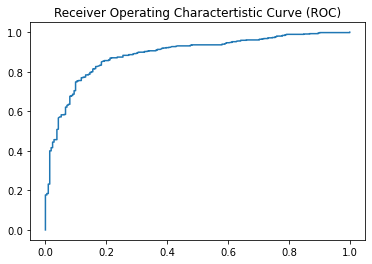

In [40]:
plt.plot(FPR, TPR)
plt.title('Receiver Operating Charactertistic Curve (ROC)')
plt.show()

To get a single value, people often use the **A**rea **U**nder the **C**urve (AUC).

In [41]:
auc = metrics.roc_auc_score(y, y_pred_prob)
print(f'The AUC of this model is {auc}')

The AUC of this model is 0.889163466354984


- What is the AUC of randomly guessing?

### Multiple independent variables

- Generalized Linear Models

**Example (2 indep.):**

Given $N$ data points $((x_1)_i, (x_2)_i, y_i)$, find parameters $\beta_0, \beta_1, \beta_2$ for the model
$$
p(X) = \frac{1}{1 + e^{-(\beta_0 +\beta_1 X_1 + \beta_2 X_2)}}
$$
that minimize the loss function
$$
L(\beta_0,\beta_1, \beta_2) = -\left(\sum_{i=1}^N y_i\log(p) + (1-y_i)\log(1-p)\right)
$$

In [44]:
model = logit(formula = 'is_private ~ outstate + s_f_ratio', data=df_college)
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.348524
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_private   No. Observations:                  777
Model:                          Logit   Df Residuals:                      774
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.4053
Time:                        20:39:06   Log-Likelihood:                -270.80
converged:                       True   LL-Null:                       -455.37
Covariance Type:            nonrobust   LLR p-value:                 6.947e-81
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1404      0.715     -1.595      0.111      -2.541       0.261
outstate       0.0005   5.14e-05     10.545      0.000       0.000       0.001
s_f_ratio     -0.1758      0.032     -5.437      0.000      -0.239      -0.112
==============================================================================
"""

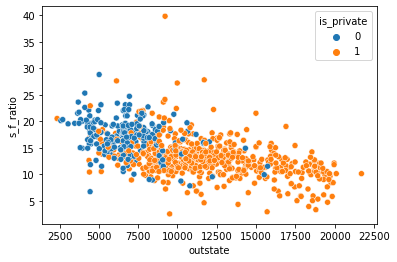

In [43]:
sns.scatterplot(x='outstate', y = 's_f_ratio', hue='is_private', data=df_college)
plt.show()

The **Decision Boundary** is the boundary between the model predicting class 0 and class 1

$$
p(X) = \frac{1}{1 + e^{-(\beta_0 +\beta_1 X_1 + \beta_2 X_2)}}=0.5
$$

equivalent to

$$
\beta_0 +\beta_1 X_1 + \beta_2 X_2 = 0\\
X_2 = -\frac{\beta_1}{\beta_2}X_1 - \frac{\beta_0}{\beta_2}
$$

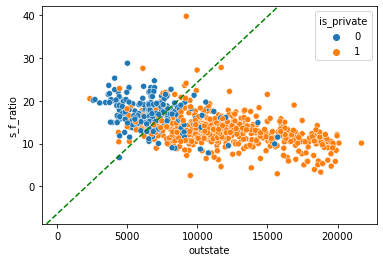

In [45]:
sns.scatterplot(x='outstate', y = 's_f_ratio', hue='is_private', data=df_college)

b0, b1, b2 = res.params
plt.axline((0,-b0/b2), slope=(-b1/b2), color='green', linestyle='--')

plt.show()

Let's what we learned about validation sets to evaluate this model.

In [46]:
train, val = train_test_split(df_college, test_size=0.2)

In [47]:
model = logit(formula = 'is_private ~ outstate + s_f_ratio', data=train)
res = model.fit()

x = val[['outstate', 's_f_ratio']]
y = val['is_private']

y_pred_prob = res.predict(x)
y_pred = (y_pred_prob >= 0.5).apply(int)

acc = metrics.accuracy_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
prec = metrics.precision_score(y, y_pred)

print(f'The Accuracy of the model on the validation set is {acc}')
print(f'The Recall of the model on the validation set is {recall}')
print(f'The Precision of the model on the validation set is {prec}')

Optimization terminated successfully.
         Current function value: 0.345285
         Iterations 8
The Accuracy of the model on the validation set is 0.8525641025641025
The Recall of the model on the validation set is 0.9
The Precision of the model on the validation set is 0.8918918918918919


In [48]:
x = train[['outstate', 's_f_ratio']]
y = train['is_private']

y_pred_prob = res.predict(x)
y_pred = (y_pred_prob >= 0.5).apply(int)

acc = metrics.accuracy_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
prec = metrics.precision_score(y, y_pred)

print(f'The Accuracy of the model on the train set is {acc}')
print(f'The Recall of the model on the train set is {recall}')
print(f'The Precision of the model on the train set is {prec}')

The Accuracy of the model on the train set is 0.855072463768116
The Recall of the model on the train set is 0.9120879120879121
The Precision of the model on the train set is 0.8924731182795699


### Imbalanced Classification

Recall that this dataset is *imbalanced* meaning that there are more class 1 than class 0 datapoints.
- Why might this cause issues during model development?
- What if there are differences between class balance from train to validation to test?

In [49]:
sum(train['is_private']) / len(train), sum(val['is_private']) / len(val)

(0.7326892109500805, 0.7051282051282052)

In [50]:
train, val = train_test_split(df_college, test_size=0.1, stratify=df_college[['is_private']])

In [51]:
sum(train['is_private']) / len(train), sum(val['is_private']) / len(val)

(0.7267525035765379, 0.7307692307692307)

Some Techniques
- Under/Over-sampling
- Weighting the loss function

In [52]:
sum(df_college['is_private']), sum(-((df_college['is_private'])-1))

(565, 212)

In [53]:
df_college.sort_values('is_private').head()

,private,apps,accept,enroll,top10perc,top25perc,f_undergrad,p_undergrad,outstate,room_board,books,personal,phd,terminal,s_f_ratio,perc_alumni,expend,grad_rate,is_private
427,No,3041,2581,1173,16,56,6441,3982,9114,4030,400,650,88,90,19.7,13,6637,53,0
632,No,4269,2594,985,27,57,6476,2592,8594,4408,494,2768,82,88,18.4,6,7618,55,0
165,No,434,412,319,10,30,1376,237,4486,2146,600,2000,50,64,16.5,28,4525,46,0
631,No,461,381,235,10,40,974,503,6600,3630,400,1675,67,67,15.2,11,6408,35,0
630,No,441,369,172,17,45,633,317,6600,3680,600,400,46,46,15.1,4,5935,64,0


In [54]:
# under-sample
df_public = df_college.sort_values('is_private')[:200]
df_private = df_college.sort_values('is_private')[-200:]
df = pd.concat((df_public, df_private))

sum(df['is_private']), sum(-((df['is_private'])-1))

(200, 200)

In [55]:
# over-sample
df_public = df_college.sort_values('is_private')[:200]
df = pd.concat((df_college, df_public))

sum(df['is_private']), sum(-((df['is_private'])-1))

(565, 412)

Let $w_i$ be the positive example weight

$$
L(\beta_0,\beta_1, \beta_2) = -\left(\sum_{i=1}^N w_i y_i\log(p) + (1-y_i)\log(1-p)\right)
$$

- What happens if $0 < w_i < 1$ or if $w_i > 1$?

In [65]:
from sklearn.linear_model import LogisticRegression

x = df_college[['outstate', 's_f_ratio']]
y = df_college['is_private']

model = LogisticRegression(class_weight={0: 1.0, 1: 10}, max_iter=400)
model.fit(x,y)

# 0,1 predictions
y_pred = model.predict(x)

# probability outputs
y_pred_prob = model.predict_proba(x)[:,1]

In [66]:
y_pred[:10], y_pred_prob[:10]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.89425287, 0.99594345, 0.9922222 , 0.99831999, 0.94763111,
        0.99849774, 0.99786435, 0.99802298, 0.99942414, 0.98972472]))

In [67]:
acc = metrics.accuracy_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
prec = metrics.precision_score(y, y_pred)

print(f'The Accuracy of the model is {acc}')
print(f'The Recall of the model is {recall}')
print(f'The Precision of the model is {prec}')

The Accuracy of the model is 0.7425997425997426
The Recall of the model is 0.9964601769911504
The Precision of the model is 0.7398160315374507


Quiz3 Next Week:
- Summary Above
- Classification Metrics
- Imbalanced Datasets